# Analyzing the WTI series

## Analysis

We will test for several classification algorithms in predicting the **direction** of the next price movement (up or down) after the inventory news from the EIA, published weekly at [investing.com](https://www.investing.com/economic-calendar/eia-crude-oil-inventories-75). This will be achieved through basic classification rules used in ML. Later on, we will implement these predictions using advanced algorithms (e.g., SVM, Neural Networks) in the Azure ML suite.

<br>
### The problem statement

The problem can be stated, mathematically, as follows:

*Given a set of $M$ features of the form $\mathbf{X}_j = (x_{1j},x_{2j},\ldots,x_{ij},\ldots,x_{Nj})$ and given the target feature to be predicted, $\mathbf{Y} = (y_{1},y_{2},\ldots,y_{i},\ldots,y_{N})$, where each $j$-feature is a time-ordered set (i.e., a time series) and $N$ is the number of such $i$-timeframes; predict the next $y_i$, i.e., predict $y_{N+1}$.*

<br>
### Definitions

For now let us assume the features are:
- The time domain and the only one not being a time series (obviously; $\mathbf{X}_1$).
- The price (look for the price with the smallest entropy in the prediction; $\mathbf{X}_2$).
- The volume ($\mathbf{X}_3$).
- The past EIA crude inventory ($\mathbf{X}_4$).
- The current EIA crude inventory ($\mathbf{X}_5$).

Therefore there will be $M=5$ features.

The target feature, $\mathbf{Y}$, will simply be: sign${\left(x_{i3}-x_{(i-1)3}\right)}$, that is, the sign (positive or negative) of the difference in price between the $i$-timeframe and the previous one.

<br><br><hr>
## Datasets

There will be two main datasets:
- The WTI candles from OANDA,
- The inventory notice from investing.

Eventually test for the need of other finantial indicators like demand, exports, imports, etc.

The characteristics of the WTI candles will be as follow:
- Minute sampling from January 2018 to the present,
- Timezones equal to America/NY,
- ISO date-time strings.

Download the investing news in the same timeframe. Formatting will be the same as the WTI dataset.

<br><br><hr>
## Outline

- [Datasets preview](datasets-preview.ipynb)
- Algorithms
    - [One-rule classification](one-rule-classification.ipynb)
    - [Naïve Bayes](naive-bayes.ipynb)

In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle as pk
from pyCBT.common.path import exist
from pyCBT.providers.eia import series
from pyCBT.providers.oanda import account
from pyCBT.providers.oanda import historical
from pyCBT.common.timezone import parse_tz, timedelta

sns.set(style="darkgrid", palette="muted", color_codes=True)

In [ ]:
# initialize the API OANDA client
oanda_api = account.Client("101-004-7835907-001")
# initialize the WTI candles
wti_candles = historical.Candles(
    client=oanda_api,
    instrument="WTICO_USD",
    resolution="M1",
    from_date="2018-01-01",
    to_date="2018-03-15",
    datetime_fmt="%Y-%m-%d %H:%M:%S.%f",
    timezone="America/New_York"
)
wti_df = wti_candles.as_dataframe()

eia_df = pd.read_csv("../data/raw/eia/investing_inventory.csv", index_col=0)

In [41]:
wti_df.index = pd.to_datetime(wti_df.index)
wti_df = wti_df.resample("1T").asfreq()

eia_df = eia_df.applymap(lambda cell: eval(cell.strip("M")) if type(cell) == str else cell)
eia_df.index = pd.to_datetime(eia_df.index)
eia_df = eia_df.resample("1T").asfreq()

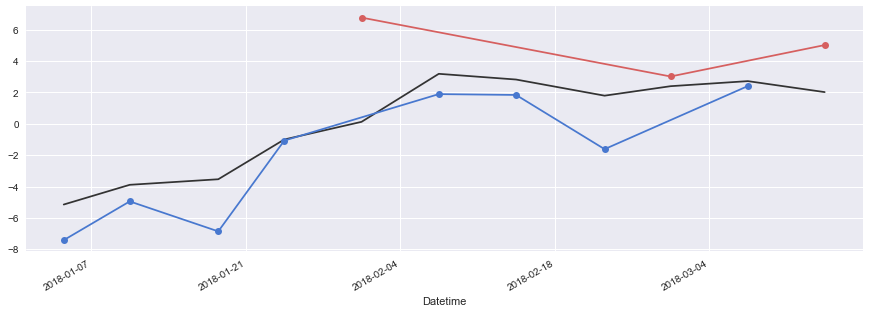

In [104]:
clean_eia = eia_df.dropna()
mask_worse = np.zeros(clean_eia.index.size, dtype=np.bool)
mask_worse[[4,8,10]] = True
mask_better = ~mask_worse

clean_eia.Forecast.plot(kind="line", figsize=(15,5), color="0.2")
clean_eia.Actual[mask_better].plot(kind="line", figsize=(15,5), color="b", marker="o")
clean_eia.Actual[mask_worse].plot(kind="line", figsize=(15,5), color="r", marker="o")

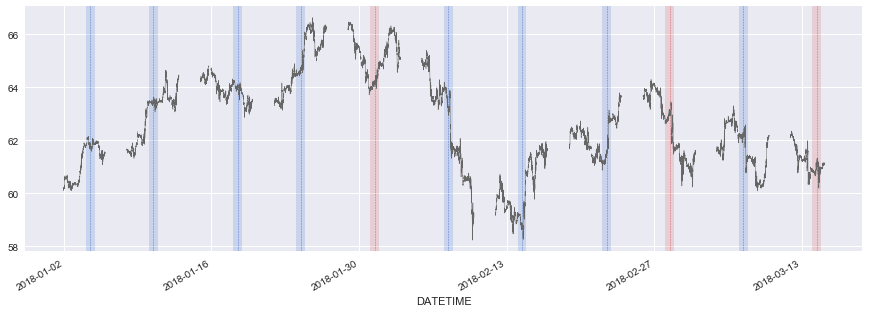

In [100]:
delta = timedelta(hours=10)
for i, datetime in enumerate(clean_eia.index):
    if mask_better[i]:
        plt.axvspan(datetime-delta, datetime+delta, lw=0, alpha=0.2, facecolor="b")
        plt.axvline(datetime, ls="--", lw=0.5, color="b")
    else:
        plt.axvspan(datetime-delta, datetime+delta, lw=0, alpha=0.2, facecolor="r")
        plt.axvline(datetime, ls="--", lw=0.5, color="r")
        
wti_df.CLOSE.plot(figsize=(15,5), color="0.4", lw=0.5)